# Machine Learning models on Mismatch Response data

In this notebook: 
- Necessary imports
- SVM model 
- Logistic Regression model
- Decision Tree model

## Imports

In [1]:
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
import seaborn as sn
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import epod_helper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 

In [2]:
df = pd.read_csv('df_avg_mmr.csv', sep = ',')
df.head()

,Group_AccToParents,mean_AF3,mean_AF4,mean_C3,mean_C4,mean_CP1,mean_CP2,mean_CP5,mean_CP6,mean_Cz,...,var_P8,var_PO3,var_PO4,var_Pz,var_T7,var_T8,ParticipantID,test,sex,age_months
0,1,0.497100,-0.397703,0.548694,-4.062833,-0.450172,-2.903579,1.669830,-4.953419,-0.373465,...,7.839750,4.203818,3.212862,2.390369,3.709684,9.156260,101,a,1,20
1,1,-2.544724,-3.113051,-1.181946,2.656960,2.329480,4.669067,-3.759660,6.810110,1.792349,...,30.329203,24.455243,35.805541,28.866266,8.541912,30.280243,103,a,0,20
2,1,-1.910624,-2.096049,-0.677231,0.042137,-0.049583,-0.360886,-2.580950,0.695467,0.369849,...,3.681435,3.790053,6.733202,4.155236,8.283880,4.745424,104,a,1,18
3,1,-0.635366,5.050880,-1.149988,-3.048080,-1.001991,-3.188275,-1.643276,-0.857845,-1.255555,...,13.430008,18.615294,12.419475,10.418090,45.620974,19.005596,105,a,0,17
4,1,5.439420,4.718995,0.300713,5.033228,-0.764506,1.128249,4.891104,8.026449,-1.161495,...,29.049972,11.006145,15.308386,3.997993,9.923045,8.829766,106,a,1,19


In [3]:
features_of_interest = df[['mean_AF3',
 'mean_F3',
 'mean_F7',
 'mean_FC1',
 'mean_FC5',
 'mean_Fp1',
 'mean_Fz',
 'kurt_AF3',
 'kurt_F3',
 'kurt_F7',
 'kurt_FC1',
 'kurt_FC5',
 'kurt_Fp1',
 'kurt_Fz',
 'skew_AF3',
 'skew_F3',
 'skew_F7',
 'skew_FC1',
 'skew_FC5',
 'skew_Fp1',
 'skew_Fz',
 'std_AF3',
 'std_F3',
 'std_F7',
 'std_FC1',
 'std_FC5',
 'std_Fp1',
 'std_Fz',
 'var_AF3',
 'var_F3',
 'var_F7',
 'var_FC1',
 'var_FC5',
 'var_Fp1',
 'var_Fz']]

In [4]:
dfcor = features_of_interest.corr()

In [5]:
dfcor

,mean_AF3,mean_F3,mean_F7,mean_FC1,mean_FC5,mean_Fp1,mean_Fz,kurt_AF3,kurt_F3,kurt_F7,...,std_FC5,std_Fp1,std_Fz,var_AF3,var_F3,var_F7,var_FC1,var_FC5,var_Fp1,var_Fz
mean_AF3,1.000000,0.718941,0.442412,0.257793,0.635212,0.806498,0.505898,0.004650,-0.002076,0.067875,...,-0.702517,-0.648821,-0.710434,-0.773339,-0.769310,-0.753506,-0.064927,-0.781534,-0.735245,-0.771275
mean_F3,0.718941,1.000000,0.521399,0.339771,0.637401,0.627596,0.505428,0.032333,0.053570,0.142266,...,-0.547260,-0.489216,-0.546519,-0.559107,-0.623237,-0.517888,-0.169616,-0.570929,-0.539578,-0.565003
mean_F7,0.442412,0.521399,1.000000,0.056625,0.619290,0.560745,0.337438,0.025724,0.037456,0.194959,...,-0.326203,-0.246992,-0.224671,-0.179842,-0.207310,-0.276539,-0.071410,-0.237041,-0.187435,-0.187475
mean_FC1,0.257793,0.339771,0.056625,1.000000,0.188104,0.224614,0.519331,-0.043497,-0.014283,0.055040,...,-0.154801,-0.190449,-0.115532,-0.045738,-0.130300,-0.093808,-0.340259,-0.074234,-0.089637,-0.057095
mean_FC5,0.635212,0.637401,0.619290,0.188104,1.000000,0.529272,0.354534,-0.028889,-0.007888,0.111742,...,-0.622774,-0.583695,-0.519522,-0.582093,-0.600614,-0.597074,-0.106556,-0.618998,-0.597356,-0.568709
mean_Fp1,0.806498,0.627596,0.560745,0.224614,0.529272,1.000000,0.514684,-0.009689,-0.015763,0.050344,...,-0.474642,-0.358556,-0.431353,-0.447799,-0.467266,-0.488175,-0.149568,-0.483800,-0.393264,-0.454056
mean_Fz,0.505898,0.505428,0.337438,0.519331,0.354534,0.514684,1.000000,-0.015095,0.041280,0.074262,...,-0.204763,-0.184111,-0.190246,-0.114412,-0.145071,-0.144469,-0.175546,-0.145061,-0.139364,-0.129079
kurt_AF3,0.004650,0.032333,0.025724,-0.043497,-0.028889,-0.009689,-0.015095,1.000000,0.968099,0.714484,...,-0.054209,-0.078302,-0.051392,-0.043803,-0.049015,-0.038188,0.027654,-0.045931,-0.053949,-0.045806
kurt_F3,-0.002076,0.053570,0.037456,-0.014283,-0.007888,-0.015763,0.041280,0.968099,1.000000,0.720376,...,-0.044390,-0.046952,-0.047927,-0.033830,-0.045004,-0.035106,-0.011152,-0.036812,-0.037296,-0.037860
kurt_F7,0.067875,0.142266,0.194959,0.055040,0.111742,0.050344,0.074262,0.714484,0.720376,1.000000,...,-0.077546,-0.088427,-0.054537,-0.036264,-0.038431,-0.069777,0.089463,-0.051332,-0.051666,-0.037105


In [6]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(dfcor, 50))

Top Absolute Correlations
var_AF3   var_Fz      0.999607
kurt_F3   kurt_Fz     0.999462
var_FC5   var_Fz      0.999060
std_AF3   var_F3      0.999041
var_AF3   var_Fp1     0.998958
var_F3    var_Fz      0.998945
kurt_AF3  kurt_Fz     0.998912
var_Fp1   var_Fz      0.998891
kurt_F3   kurt_FC1    0.998854
var_AF3   var_FC5     0.998832
kurt_FC1  kurt_Fp1    0.998787
var_F7    var_FC5     0.998764
std_AF3   var_Fp1     0.998754
var_F3    var_FC5     0.998729
kurt_F3   kurt_FC5    0.998673
kurt_FC1  kurt_Fz     0.998554
std_AF3   var_Fz      0.998406
var_FC5   var_Fp1     0.998384
kurt_AF3  kurt_F3     0.998383
kurt_F3   kurt_Fp1    0.998371
var_F3    var_Fp1     0.998219
std_AF3   var_FC5     0.998198
kurt_Fp1  kurt_Fz     0.998049
var_AF3   var_F3      0.998039
kurt_AF3  kurt_Fp1    0.998023
kurt_FC5  kurt_Fz     0.997963
          kurt_Fp1    0.997458
kurt_FC1  kurt_FC5    0.997395
std_AF3   var_AF3     0.997365
kurt_AF3  kurt_FC1    0.997308
std_AF3   std_Fz      0.997222
          var

## Split data

In [29]:
y = df['Group_AccToParents'].values # dependant variable
#X = df[['mean_AF3',
# 'mean_F3',
# 'mean_F7',
# 'mean_FC1',
# 'mean_FC5',
# 'mean_Fp1',
# 'mean_Fz',
# 'kurt_AF3',
# 'kurt_F3',
# 'kurt_F7',
# 'kurt_FC1',
# 'kurt_FC5',
# 'kurt_Fp1',
# 'kurt_Fz',
# 'skew_AF3',
# 'skew_F3',
# 'skew_F7',
# 'skew_FC1',
# 'skew_FC5',
# 'skew_Fp1',
# 'skew_Fz',
# 'std_AF3',
# 'std_F3',
# 'std_F7',
# 'std_FC1',
# 'std_FC5',
# 'std_Fp1',
# 'std_Fz'
#    ]]
#
X = df[[ 'mean_F7',
 'mean_Fz',
 'kurt_F7',
 'kurt_Fz',
 'skew_F7',
 'skew_Fz',
 'std_F7',
 'std_Fz',
 'var_F7',
 'var_Fz']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Scale data

In [8]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## SVM model

In [30]:
svm = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 1]}
clf = GridSearchCV(svm, parameters)
clf.fit(X_train, y_train)

sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [31]:
clf.best_params_

{'C': 1, 'kernel': 'rbf'}

In [32]:
clf.score(X_train, y_train)

0.6333333333333333

In [33]:
svm = SVC(C=1, kernel='linear', random_state=False)
svm.fit(X_train, y_train)

SVC(C=1, kernel='linear', random_state=False)

In [34]:
y_pred = svm.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.488


In [35]:
y_pred

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1])

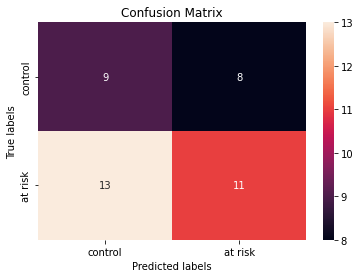

In [36]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [37]:
# with kfold cross validation
k = 6
kf = KFold(n_splits=k, shuffle=True, random_state=None)
model = svm
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.29411764705882354, 0.5294117647058824, 0.47058823529411764, 0.35294117647058826, 0.47058823529411764, 0.375]
Avg accuracy : 0.41544117647058826


## Logistic Regression model

In [38]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [39]:
y_pred = lr.predict(X_test)

In [40]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.438


In [41]:
y_pred

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

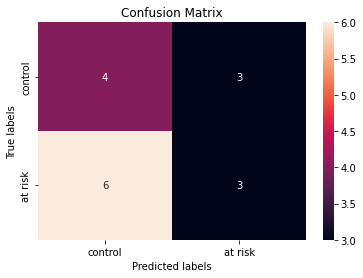

In [42]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [43]:
# with kfold cross validation
k = 6
kf = KFold(n_splits=k, shuffle = True, random_state=None)
model = lr
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.5294117647058824, 0.5294117647058824, 0.47058823529411764, 0.35294117647058826, 0.23529411764705882, 0.625]
Avg accuracy : 0.4571078431372549


## Decision Tree model

In [44]:
dt = tree.DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [45]:
y_pred = dt.predict(X_test)

In [46]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.562


In [47]:
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0])

[Text(0.4880952380952381, 0.9166666666666666, 'X[8] <= 7.673\ngini = 0.5\nsamples = 85\nvalue = [43, 42]'),
 Text(0.2857142857142857, 0.75, 'X[0] <= 1.431\ngini = 0.432\nsamples = 38\nvalue = [26, 12]'),
 Text(0.23809523809523808, 0.5833333333333334, 'X[3] <= -0.168\ngini = 0.382\nsamples = 35\nvalue = [26, 9]'),
 Text(0.09523809523809523, 0.4166666666666667, 'X[2] <= 0.035\ngini = 0.165\nsamples = 22\nvalue = [20, 2]'),
 Text(0.047619047619047616, 0.25, 'gini = 0.0\nsamples = 15\nvalue = [15, 0]'),
 Text(0.14285714285714285, 0.25, 'X[2] <= 0.102\ngini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(0.09523809523809523, 0.08333333333333333, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.19047619047619047, 0.08333333333333333, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.38095238095238093, 0.4166666666666667, 'X[3] <= 0.583\ngini = 0.497\nsamples = 13\nvalue = [6, 7]'),
 Text(0.3333333333333333, 0.25, 'X[0] <= -1.829\ngini = 0.219\nsamples = 8\nvalue = [1, 7]'),
 Text(0.285714

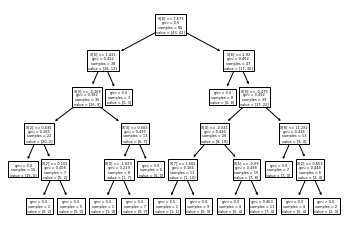

In [48]:
tree.plot_tree(dt)

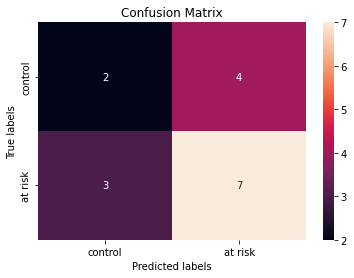

In [49]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [50]:
# with kfold cross validation
k = 6
kf = KFold(n_splits=k, shuffle=True, random_state=None)
model = tree.DecisionTreeClassifier(max_depth=5)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.4117647058823529, 0.5294117647058824, 0.5294117647058824, 0.5882352941176471, 0.4117647058823529, 0.5625]
Avg accuracy : 0.5055147058823529
